In [1]:
# Packages for general use
import numpy as np
import pandas as pd

# For handling data
from sklearn import preprocessing, metrics, tree
import rasterio as rio

# Modeling
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Event-specific Matrices

In [2]:
all_events_feats = pd.read_csv("Data/data_for_model.csv")

In [3]:
all_events_feats.columns
# all_events_feats.groupby('EVENT_TYPE').count()

Index(['EVENT_TYPE', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'DURATION',
       'CLOSEST_HOSPITAL_DIST', 'NUM_COUNTY_HOSPITALS', 'NUM_STATE_HOSPITALS',
       'EPISODE_LENGTH', 'EVENT_LENGTH', 'DEATHS',
       'FLOOD_CAUSE_Dam / Levee Break', 'FLOOD_CAUSE_Heavy Rain',
       'FLOOD_CAUSE_Heavy Rain / Burn Area',
       'FLOOD_CAUSE_Heavy Rain / Snow Melt',
       'FLOOD_CAUSE_Heavy Rain / Tropical System',
       'FLOOD_CAUSE_Planned Dam Release', 'LAND_COVER_CLASS_1.0',
       'LAND_COVER_CLASS_2.0', 'LAND_COVER_CLASS_3.0', 'LAND_COVER_CLASS_5.0',
       'LAND_COVER_CLASS_6.0', 'LAND_COVER_CLASS_7.0', 'LAND_COVER_CLASS_8.0',
       'LAND_COVER_CLASS_9.0', 'LAND_COVER_CLASS_10.0',
       'LAND_COVER_CLASS_11.0', 'LAND_COVER_CLASS_12.0',
       'LAND_COVER_CLASS_13.0', 'LAND_COVER_CLASS_14.0',
       'LAND_COVER_CLASS_15.0', 'LAND_COVER_CLASS_17.0', 'TOR_F_SCALE_EF0',
       'TOR_F_SCALE_EF1', 'TOR_F_SCALE_EF2', 'TOR_F_SCALE_EF3',
       'TOR_F_SCALE_EF4', 'TOR_F_SCALE_EF5', 'TOR_F_SCAL

In [4]:
#Standardize non-binary columns
mlb = preprocessing.StandardScaler()
feature_column_names = ['MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH', 'DURATION',
       'CLOSEST_HOSPITAL_DIST', 'NUM_COUNTY_HOSPITALS',
       'NUM_STATE_HOSPITALS', 'EPISODE_LENGTH', 'EVENT_LENGTH',]
feature_column = all_events_feats[feature_column_names]

#mask = feature_column.notnull() #Save location non-missing values, allows us to restore original indices after filtering na's

feature_matrix = mlb.fit_transform(all_events_feats[feature_column_names]) #Drop missing values and encode

#df = pd.DataFrame(feature_matrix, index=all_events_feats.index[mask], columns=feature_column_name+"_"+mlb.classes_) \
#    .reindex(all_events_feats.index, fill_value=0)  #restore original matrix with missing values - encoded as all 0's
    
#all_events_feats = all_events_feats.join(df).drop([feature_column_name], axis=1)
all_events_feats[feature_column_names] = feature_matrix

In [5]:
event_type = 'Wind'
wind_events = all_events_feats[all_events_feats['EVENT_TYPE']==event_type].pipe(
    pd.DataFrame.drop,
    labels=all_events_feats.filter(regex='EVENT|TOR|FLOOD|NARRATIVE'),
    axis=1, 
    inplace=False
)
wind_events.head(5)

,MAGNITUDE,DURATION,CLOSEST_HOSPITAL_DIST,NUM_COUNTY_HOSPITALS,NUM_STATE_HOSPITALS,EPISODE_LENGTH,DEATHS,LAND_COVER_CLASS_1.0,LAND_COVER_CLASS_2.0,LAND_COVER_CLASS_3.0,...,FATALITY_LOCATION_Long Span Roof,FATALITY_LOCATION_Mobile/Trailer Home,FATALITY_LOCATION_Other/Unknown,FATALITY_LOCATION_Outside/Open Areas,FATALITY_LOCATION_Permanent Home,FATALITY_LOCATION_Permanent Structure,FATALITY_LOCATION_School,FATALITY_LOCATION_Telephone,FATALITY_LOCATION_Under Tree,FATALITY_LOCATION_Vehicle/Towed Trailer
0,-1.128760,0.0,NaN,-0.194345,0.111398,-0.283799,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.059892,0.0,NaN,-0.194345,0.143012,-0.067288,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.340933,0.0,NaN,-0.194345,0.111398,0.026425,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0.073716,0.0,NaN,-0.194345,-0.062482,0.307566,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,-0.527522,0.0,NaN,0.269730,-0.117808,-0.471226,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
event_type = 'Tornado'
tor_events = all_events_feats[all_events_feats['EVENT_TYPE']==event_type].pipe(
    pd.DataFrame.drop,
    labels=all_events_feats.filter(regex='EVENT|FLOOD|NARRATIVE|MAGNITUDE'),
    axis=1, 
    inplace=False
)
tor_events.head(5)

,TOR_LENGTH,TOR_WIDTH,DURATION,CLOSEST_HOSPITAL_DIST,NUM_COUNTY_HOSPITALS,NUM_STATE_HOSPITALS,EPISODE_LENGTH,DEATHS,LAND_COVER_CLASS_1.0,LAND_COVER_CLASS_2.0,...,FATALITY_LOCATION_Long Span Roof,FATALITY_LOCATION_Mobile/Trailer Home,FATALITY_LOCATION_Other/Unknown,FATALITY_LOCATION_Outside/Open Areas,FATALITY_LOCATION_Permanent Home,FATALITY_LOCATION_Permanent Structure,FATALITY_LOCATION_School,FATALITY_LOCATION_Telephone,FATALITY_LOCATION_Under Tree,FATALITY_LOCATION_Vehicle/Towed Trailer
12,-1.329936,0.219557,0.0,-0.110321,0.037692,-0.094097,-0.471226,1,0,0,...,0,0,0,0,1,0,0,0,0,0
16,-0.624952,-0.552269,0.0,-0.117146,0.037692,-0.204748,-0.471226,2,0,0,...,0,0,0,0,0,0,0,0,0,1
17,-0.624952,-0.552269,0.0,-0.146693,0.037692,-0.204748,-0.471226,2,0,0,...,0,0,0,0,0,0,0,0,0,1
38,-0.272460,-0.873863,0.0,-0.148474,0.037692,-0.204748,-0.471226,1,0,0,...,0,0,0,0,1,0,0,0,0,0
39,-0.272460,-0.873863,0.0,-0.145246,0.037692,-0.204748,-0.471226,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
event_type = 'Flood'
flood_events = all_events_feats[all_events_feats['EVENT_TYPE']==event_type].pipe(
    pd.DataFrame.drop,
    labels=all_events_feats.filter(regex='EVENT|TOR|MAGNITUDE|NARRATIVE'),
    axis=1, 
    inplace=False
)
flood_events.head(5)

,DURATION,CLOSEST_HOSPITAL_DIST,NUM_COUNTY_HOSPITALS,NUM_STATE_HOSPITALS,EPISODE_LENGTH,DEATHS,FLOOD_CAUSE_Dam / Levee Break,FLOOD_CAUSE_Heavy Rain,FLOOD_CAUSE_Heavy Rain / Burn Area,FLOOD_CAUSE_Heavy Rain / Snow Melt,...,FATALITY_LOCATION_Long Span Roof,FATALITY_LOCATION_Mobile/Trailer Home,FATALITY_LOCATION_Other/Unknown,FATALITY_LOCATION_Outside/Open Areas,FATALITY_LOCATION_Permanent Home,FATALITY_LOCATION_Permanent Structure,FATALITY_LOCATION_School,FATALITY_LOCATION_Telephone,FATALITY_LOCATION_Under Tree,FATALITY_LOCATION_Vehicle/Towed Trailer
18,0.0,-0.170574,0.269730,0.601424,-0.248253,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19,0.0,-0.176608,0.037692,0.601424,-0.248253,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0.0,-0.136093,0.269730,3.193818,0.346344,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0.0,-0.109655,2.358065,3.193818,0.346344,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,0.0,-0.181610,1.429916,3.193818,0.346344,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Models (Tornadoes)

In [139]:
event_matrix = tor_events
rand_seed = 123
full_x = event_matrix.drop(['DEATHS'],axis=1,inplace=False)
full_y = event_matrix['DEATHS']
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(full_x, full_y, train_size=0.8, random_state=rand_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train_1, y_train_1, train_size=0.8, random_state=rand_seed)
y_train.mean()

3.9435294117647057

In [107]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = model.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", model.score(x_train, y_train))
print("Testing accuracy: ", model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='max_error'))
weights = {"Linear":model.coef_}
df = pd.DataFrame(weights)
df.index = x_train.columns

MAE on training set  2.713147725769235
MAE on testing set  2.400473944482946
Cross validation set:  -2.9377890416372208
Training accuracy:  0.7422334404169714
Testing accuracy:  0.3709905056002396
Cross validation accuracy:  [-3.99826445 -4.12143629 -2.22055224 -2.32838021 -2.628587   -2.92332575
 -2.44227955 -3.51735188 -1.90706406 -3.29064899]
Cross validation accuracy:  [-1.39387553 -1.33672677 -1.29192014 -1.46636557 -1.50053787 -1.33604656
 -1.17154659 -1.2096187  -1.00042412 -1.13022777]
Cross validation accuracy:  [-68.79626431 -69.42425256 -17.39811492 -15.03061083 -29.86562741
 -29.2591885  -24.44238314 -67.0332151  -10.698035   -68.60510143]


In [117]:
ridgemodel = linear_model.Ridge(alpha=0.5)
ridgemodel.fit(x_train, y_train)
df['Ridge'] = ridgemodel.coef_
preds = ridgemodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = ridgemodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", ridgemodel.score(x_train, y_train))
print("Testing accuracy: ", ridgemodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  2.7681370134536283
MAE on testing set  2.411621933412783
Cross validation set:  -2.9577066757162074
Training accuracy:  0.7393472765426321
Testing accuracy:  0.36694207551684077
Cross validation accuracy:  [-4.05667384 -4.19227902 -2.29541303 -2.31624872 -2.67823538 -2.95536252
 -2.50394298 -3.45520373 -1.94152916 -3.18217837]
Cross validation accuracy:  [-1.38922365 -1.19360677 -1.50841911 -1.4257943  -1.67039314 -1.30900183
 -1.19478496 -1.03420444 -1.06813218 -1.25457772]
Cross validation accuracy:  [-73.72963159 -74.86844516 -16.0689507  -14.86050119 -29.26433826
 -27.86475899 -24.83179958 -56.67225069 -11.29045904 -58.17509315]


In [118]:
lassomodel = linear_model.Lasso(alpha=0.1)
lassomodel.fit(x_train, y_train)
df['Lasso'] = lassomodel.coef_
preds = lassomodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = lassomodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", lassomodel.score(x_train, y_train))
print("Testing accuracy: ", lassomodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  2.5006414400993053
MAE on testing set  2.037223035723083
Cross validation set:  -2.6194774842481463
Training accuracy:  0.7203888518301895
Testing accuracy:  0.41676908476165936
Cross validation accuracy:  [-4.04890205 -4.32528963 -1.89624819 -2.01615    -2.1119392  -2.47305658
 -1.96638491 -2.91273294 -1.69540134 -2.74867   ]
Cross validation accuracy:  [-1.31972799 -1.19257846 -1.04980992 -0.9792767  -0.90297392 -1.00188223
 -0.86194484 -0.7258411  -0.62155393 -0.74568016]
Cross validation accuracy:  [-89.76175516 -90.68636765 -13.58844907 -16.11789269 -32.24202088
 -24.82180398 -18.9453554  -55.36675635  -9.88762899 -55.29610966]


In [119]:
elmodel = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.7)
elmodel.fit(x_train, y_train)
df['ElasticNet'] = elmodel.coef_
preds = elmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = elmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", elmodel.score(x_train, y_train))
print("Testing accuracy: ", elmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  3.2846997819732455
MAE on testing set  2.7248610257742496
Cross validation set:  -3.1663515912905873
Training accuracy:  0.09079347919467362
Testing accuracy:  0.16251227895806752
Cross validation accuracy:  [-5.81675347 -5.81474162 -2.97404627 -2.17886685 -2.87669167 -2.02189946
 -2.40056497 -2.84269316 -2.50467781 -2.23258064]
Cross validation accuracy:  [-1.95338752 -1.72978964 -2.18394403 -1.6920915  -1.7248505  -1.68614587
 -1.72190491 -1.95027138 -2.07727865 -1.56054866]
Cross validation accuracy:  [-156.18141595 -156.01916896  -16.04360617  -16.68114667  -45.0998673
   -7.19927166  -19.07921793  -16.11450237   -9.82671276  -11.67559099]


In [124]:
sgdmodel = linear_model.SGDRegressor()
sgdmodel.fit(x_train, y_train)
df['SGD'] = sgdmodel.coef_
preds = sgdmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = sgdmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", sgdmodel.score(x_train, y_train))
print("Testing accuracy: ", sgdmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  2.967717213259933
MAE on testing set  2.5695867267966888


c:\users\caroshi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1188: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Cross validation set:  -3.128446489014581
Training accuracy:  0.7291688996267058
Testing accuracy:  0.3157895133247629
Cross validation accuracy:  [-4.21060953 -4.28648669 -2.64420914 -2.39092826 -2.85675725 -3.16486507
 -2.97073073 -3.54135805 -2.19973277 -3.23170761]
Cross validation accuracy:  [-1.4701457  -1.16550314 -1.73477411 -1.20323409 -1.71872243 -1.46226349
 -1.52781313 -1.28007125 -1.13110005 -1.28568133]
Cross validation accuracy:  [-79.55667283 -79.80406966 -14.52844958 -14.72468818 -27.51376596
 -26.65359289 -27.56808728 -48.48556542 -13.0064734  -49.83295746]


c:\users\caroshi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1188: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [120]:
print("Cross validation accuracy: ", cross_val_score(sgdmodel, full_x, full_y, cv=10, scoring='max_error'))

Cross validation accuracy:  [ -18.01868386  -13.36599997  -15.21596538  -10.91279923 -130.33257083
  -39.76133875  -68.67050717   -9.50984968  -14.86804012  -16.06898575]


c:\users\caroshi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1188: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [125]:
sgdhmodel = linear_model.SGDRegressor(loss='huber')
sgdhmodel.fit(x_train,y_train)
df['SGD_huber'] = sgdhmodel.coef_
preds = sgdhmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = sgdhmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", sgdhmodel.score(x_train, y_train))
print("Testing accuracy: ", sgdhmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  2.8456990739781918
MAE on testing set  2.046534833367052
Cross validation set:  -2.677254237619757
Training accuracy:  -0.037303165367402524
Testing accuracy:  -0.06560141850897461
Cross validation accuracy:  [-5.75056996 -5.46407363 -2.68853869 -1.8164392  -2.30157681 -1.41855965
 -1.26341839 -2.30439354 -1.40582833 -2.36056166]
Cross validation accuracy:  [-0.57487115 -0.4390647  -0.6429632  -0.34036754 -0.48379508 -0.49768671
 -0.39212426 -0.42149519 -0.45421356 -0.68180711]
Cross validation accuracy:  [-159.20894244 -159.13042281  -22.72742971  -21.24738688  -49.87511317
  -10.08291188  -25.46650903  -22.69694501  -14.79194949  -18.51007374]


In [122]:
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))

Cross validation accuracy:  [-1.82096913 -1.63468566 -1.55122068 -0.9508549  -7.1190863  -3.25211987
 -4.08397675 -1.26377908 -1.97184656 -1.23871802]


In [123]:
df

,Linear,Ridge,Lasso,ElasticNet,SGD_huber
TOR_LENGTH,-2.083041e-01,-0.274802,-0.000000,0.000000,0.058673
TOR_WIDTH,4.565050e-01,0.411286,0.510877,1.449282,0.055172
DURATION,-8.856804e-14,0.000000,0.000000,0.000000,0.000000
CLOSEST_HOSPITAL_DIST,-6.265927e+00,-3.393424,-0.000000,-0.000000,-0.078822
NUM_COUNTY_HOSPITALS,4.244036e-01,0.469105,0.222810,0.000000,0.010163
NUM_STATE_HOSPITALS,6.525734e-01,0.621031,0.000000,-0.000000,0.006843
EPISODE_LENGTH,-4.590816e-01,-0.484997,-0.000000,0.000000,0.026748
LAND_COVER_CLASS_1.0,-5.146148e+00,-4.394524,-0.000000,-0.000000,0.008911
LAND_COVER_CLASS_2.0,-7.105427e-15,0.000000,0.000000,0.000000,0.000000
LAND_COVER_CLASS_3.0,1.160208e+01,8.030698,0.000000,0.000000,0.002675


## Tree Models

In [126]:
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(x_train_1,y_train_1)
preds = dtree.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = dtree.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(dtree, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", dtree.score(x_train_1, y_train_1))
print("Testing accuracy: ", dtree.score(x_test, y_test))
values = cross_val_score(dtree, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print(values.mean())

print("Cross validation accuracy: ", cross_val_score(dtree, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='max_error'))

weights = {"DecisionTree":dtree.feature_importances_*100}
df_tree = pd.DataFrame(weights)
df_tree.index = x_train.columns

MAE on training set  2.33312844849767
MAE on testing set  2.1778899115170036
Cross validation set:  -2.33807590627926
Training accuracy:  0.880827372560543
Testing accuracy:  0.6975003993299013
-2.33807590627926
Cross validation accuracy:  [-2.55965107 -2.2123336  -2.01079064 -1.78252319 -6.44472275 -3.41016403
 -8.22438796 -1.7553273  -2.49108284 -2.21488068]
Cross validation accuracy:  [-1.01212541 -0.85414054 -1.15439131 -1.54569296 -1.57230478 -1.54003906
 -1.4474263  -1.02902432 -0.85890274 -1.17368555]
Cross validation accuracy:  [ -16.20959978   -8.97880355  -18.29835541   -8.81169553 -128.50742146
  -48.14355469 -131.58670753   -8.41133723  -11.80784052  -16.3764056 ]


In [152]:
import matplotlib.pyplot as pyplot

0
MAE on training set  3.149635452267031
MAE on testing set  2.7441942792410083
Cross validation set:  -3.327597482216249
1
MAE on training set  2.33312844849767
MAE on testing set  2.1778899115170036
Cross validation set:  -2.33807590627926
2
MAE on training set  2.0755690596353893
MAE on testing set  2.0093201894763797
Cross validation set:  -2.0950215368222973
3
MAE on training set  1.709455547022743
MAE on testing set  1.7026388488072952
Cross validation set:  -1.771490427016022
4
MAE on training set  1.4949437950568463
MAE on testing set  1.4722594604779602
Cross validation set:  -1.563206328793072
5
MAE on training set  1.3683079797790918
MAE on testing set  1.3937042421425108
Cross validation set:  -1.6356586097233232
6
MAE on training set  1.2374755315378128
MAE on testing set  1.138039402513111
Cross validation set:  -1.5406018936741996
7
MAE on training set  0.9781754447167982
MAE on testing set  0.973468375688002
Cross validation set:  -1.679293772957704
8
MAE on training se

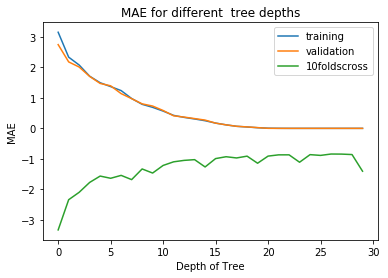

In [158]:
training = []
validationset = []
crossval = []
for x in range(30):
    dt5model = DecisionTreeRegressor(max_depth=x+1)
    dt5model.fit(x_train_1,y_train_1)
    df_tree['DecisionTree5'] = dt5model.feature_importances_*100
    preds = dt5model.predict(x_train_1)
    print(x)
    print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
    training.append(metrics.mean_absolute_error(y_train_1, preds))
    preds = dt5model.predict(x_test)
    print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
    validationset.append(metrics.mean_absolute_error(y_test, preds))
    values = cross_val_score(dt5model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
    print("Cross validation set: ", values.mean())
    
    crossval.append(values.mean())
pyplot.plot(training, label = "training" )
pyplot.plot(validationset,  label = "validation")
pyplot.plot(crossval, label = "10foldscross")
pyplot.legend()
pyplot.title("MAE for different  tree depths")
pyplot.xlabel("Depth of Tree")
pyplot.ylabel("MAE")
print("Training accuracy: ", dt5model.score(x_train_1, y_train_1))
print("Testing accuracy: ", dt5model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='max_error'))

In [127]:
dt5model = DecisionTreeRegressor(max_depth=5)
dt5model.fit(x_train_1,y_train_1)
df_tree['DecisionTree5'] = dt5model.feature_importances_*100
preds = dt5model.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = dt5model.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(dt5model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", dt5model.score(x_train_1, y_train_1))
print("Testing accuracy: ", dt5model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='max_error'))

MAE on training set  1.4949437950568463
MAE on testing set  1.4722594604779602
Cross validation set:  -1.884186571471428
Training accuracy:  0.9490245485075018
Testing accuracy:  0.8387174103303121
Cross validation accuracy:  [-2.01176972 -1.55543672 -1.93842705 -1.33012548 -6.19283796 -2.85161397
 -7.95159277 -1.91718652 -1.70336467 -1.46776094]
Cross validation accuracy:  [-0.91428571 -1.03671706 -1.18181818 -1.08779443 -0.86353468 -1.04347826
 -1.55294118 -1.0403397  -1.07643312 -0.78888889]
Cross validation accuracy:  [ -14.08571429   -9.5         -11.43076923   -4.5890411  -137.
  -17.5        -143.           -6.33898305  -10.5         -16.33333333]


In [128]:
bmodel = BaggingRegressor(base_estimator=dtree)
bmodel.fit(x_train,y_train)

# base = model.base_estimator_.fit(x_train, y_train)
# df_tree['BaggingTreeBase'] = base.feature_importances_*100 #model.base_estimator_.feature_importances_
newfeature_importances = np.mean([
    tree.feature_importances_ for tree in bmodel.estimators_
], axis=0)
df_tree['BagginTreeAvg'] = newfeature_importances
preds = bmodel.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = bmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(bmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", bmodel.score(x_train, y_train))
print("Testing accuracy: ", bmodel.score(x_test, y_test))
print("Cross validation MAE: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='max_error'))

MAE on training set  2.4430864522558786
MAE on testing set  2.3225600172824405
Cross validation set:  -2.7912628792407714
Training accuracy:  0.8447286343150184
Testing accuracy:  0.3890206287342297
Cross validation MAE:  [-2.36135957 -2.06227706 -1.80024543 -1.6720181  -6.35697292 -3.94351604
 -7.68610393 -1.69892711 -2.33388259 -2.04005706]
Cross validation accuracy:  [-1.90231112 -1.65668722 -1.7348827  -1.82512833 -1.42738967 -1.8037027
 -1.50012848 -1.79746994 -1.8293813  -1.93603816]
Cross validation accuracy:  [ -13.29995873   -6.24775783  -11.18572516   -5.12536248 -142.92761736
  -12.79824133 -143.           -5.21868566  -17.96682142  -20.24203526]


In [129]:
rfmodel = RandomForestRegressor()
rfmodel.fit(x_train, y_train)
df_tree['RandomForest'] = rfmodel.feature_importances_*100
preds = rfmodel.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = rfmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(rfmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Training accuracy: ", rfmodel.score(x_train, y_train))
print("Testing accuracy: ", rfmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='max_error'))

MAE on training set  0.7818984962406016
MAE on testing set  1.222523364485981
Training accuracy:  0.9572158389737705
Testing accuracy:  0.8430923335865026
Cross validation accuracy:  [-1.70641791 -1.55791045 -1.34731343 -0.93522388 -5.76552239 -3.60575758
 -7.20363636 -1.31742424 -1.55984848 -1.32909091]
Cross validation accuracy:  [-0.69  -0.69  -0.74  -0.59  -0.82  -1.23  -1.3   -0.635 -0.695 -0.66 ]
Cross validation accuracy:  [ -12.05   -5.55  -10.59   -3.44 -137.98  -37.02 -130.48   -5.9   -13.38
  -17.54]


In [19]:
df_tree

,DecisionTree,DecisionTree5,BagginTreeAvg,RandomForest
TOR_LENGTH,46.015614,9.274940,0.297242,15.860476
TOR_WIDTH,0.000000,34.596589,0.026219,3.138983
DURATION,0.000000,0.000000,0.000000,0.000000
CLOSEST_HOSPITAL_DIST,0.000000,0.374783,0.000000,3.414959
NUM_COUNTY_HOSPITALS,0.000000,0.000000,0.000000,4.100639
NUM_STATE_HOSPITALS,0.000000,0.000000,0.039692,1.608653
EPISODE_LENGTH,0.000000,0.000000,0.028397,2.723155
LAND_COVER_CLASS_1.0,0.000000,0.000000,0.000000,0.002055
LAND_COVER_CLASS_2.0,0.000000,0.000000,0.000000,0.000000
LAND_COVER_CLASS_3.0,0.000000,0.000000,0.000000,0.222153


# Wind Events

In [184]:
event_matrix = wind_events
event_matrix = event_matrix.dropna()
rand_seed = 123
full_x = event_matrix.drop(['DEATHS'],axis=1,inplace=False)
full_y = event_matrix['DEATHS']
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(full_x, full_y, train_size=0.8, random_state=rand_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train_1, y_train_1, train_size=0.8, random_state=rand_seed)
y_train.mean()

1.2410714285714286

0
MAE on training set  0.41193216232586305
MAE on testing set  0.5176155865132243
Cross validation set:  -0.6450282066149645
1
MAE on training set  0.38432737248526716
MAE on testing set  0.5907801598591071
Cross validation set:  -0.6244088091633871
2
MAE on training set  0.31035646258503397
MAE on testing set  0.47039909297052157
Cross validation set:  -0.6186767373198562
3
MAE on training set  0.2746328834564128
MAE on testing set  0.37612616595459725
Cross validation set:  -0.6431370197872167
4
MAE on training set  0.2560243428577858
MAE on testing set  0.3284156685242925
Cross validation set:  -0.729163014707686
5
MAE on training set  0.22788252965672315
MAE on testing set  0.2845971680649099
Cross validation set:  -0.6726942410519288
6
MAE on training set  0.1978316616353426
MAE on testing set  0.21215511085142988
Cross validation set:  -0.6679370127150784
7
MAE on training set  0.1779120879120879
MAE on testing set  0.16631868131868133
Cross validation set:  -0.6897512846654597
8

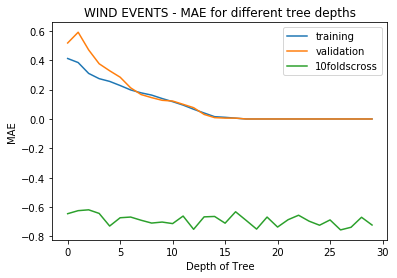

In [187]:
training = []
validationset = []
crossval = []
for x in range(30):
    dt5model = DecisionTreeRegressor(max_depth=x+1)
    dt5model.fit(x_train_1,y_train_1)
#     df_tree['DecisionTree5'] = dt5model.feature_importances_*100
    preds = dt5model.predict(x_train_1)
    print(x)
    print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
    training.append(metrics.mean_absolute_error(y_train_1, preds))
    preds = dt5model.predict(x_test)
    print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
    validationset.append(metrics.mean_absolute_error(y_test, preds))
    values = cross_val_score(dt5model, x_test, y_test, cv=10, scoring='neg_mean_absolute_error')
    print("Cross validation set: ", values.mean())
    
    crossval.append(values.mean())
pyplot.plot(training, label = "training" )
pyplot.plot(validationset,  label = "validation")
pyplot.plot(crossval, label = "10foldscross")
pyplot.legend()
pyplot.title("WIND EVENTS - MAE for different tree depths")
pyplot.xlabel("Depth of Tree")
pyplot.ylabel("MAE")
print("Training accuracy: ", dt5model.score(x_train_1, y_train_1))
print("Testing accuracy: ", dt5model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='max_error'))

Text(0, 0.5, 'MAE')

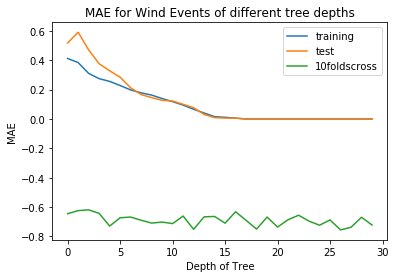

In [188]:
pyplot.plot(training, label = "training" )
pyplot.plot(validationset,  label = "test")
pyplot.plot(crossval, label = "10foldscross")
pyplot.legend()
pyplot.title("MAE for Wind Events of different tree depths")
pyplot.xlabel("Depth of Tree")
pyplot.ylabel("MAE")

In [189]:
event_matrix = flood_events
event_matrix = event_matrix.dropna()
rand_seed = 123
full_x = event_matrix.drop(['DEATHS'],axis=1,inplace=False)
full_y = event_matrix['DEATHS']
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(full_x, full_y, train_size=0.8, random_state=rand_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train_1, y_train_1, train_size=0.8, random_state=rand_seed)
y_train.mean()

1.4110047846889953

0
MAE on training set  0.6541477604642421
MAE on testing set  0.6933601871265239
Cross validation set:  -0.6989953563018008
1
MAE on training set  0.6225826970837872
MAE on testing set  0.6523287521982389
Cross validation set:  -0.6881552797871462
2
MAE on training set  0.590813328807626
MAE on testing set  0.613112283905274
Cross validation set:  -0.7138535936576031
3
MAE on training set  0.5232897972175204
MAE on testing set  0.540484128577088
Cross validation set:  -0.7061284181900807
4
MAE on training set  0.49882319518638096
MAE on testing set  0.5224708748236709
Cross validation set:  -0.7061151083672275
5
MAE on training set  0.4737634357534516
MAE on testing set  0.46641087312399465
Cross validation set:  -0.683208460416955
6
MAE on training set  0.45772844237824717
MAE on testing set  0.44066443050232706
Cross validation set:  -0.6573045548703037
7
MAE on training set  0.4403309002785477
MAE on testing set  0.4184642486206988
Cross validation set:  -0.6483762427816503
8
MAE on

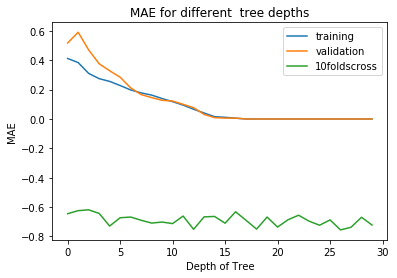

In [190]:
trainingf = []
validationsetf = []
crossvalf = []
for x in range(30):
    dt5model = DecisionTreeRegressor(max_depth=x+1)
    dt5model.fit(x_train_1,y_train_1)
#     df_tree['DecisionTree5'] = dt5model.feature_importances_*100
    preds = dt5model.predict(x_train_1)
    print(x)
    print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
    trainingf.append(metrics.mean_absolute_error(y_train_1, preds))
    preds = dt5model.predict(x_test)
    print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
    validationsetf.append(metrics.mean_absolute_error(y_test, preds))
    values = cross_val_score(dt5model, x_test, y_test, cv=10, scoring='neg_mean_absolute_error')
    print("Cross validation set: ", values.mean())
    
    crossvalf.append(values.mean())
pyplot.plot(training, label = "training" )
pyplot.plot(validationset,  label = "validation")
pyplot.plot(crossval, label = "10foldscross")
pyplot.legend()
pyplot.title("MAE for different  tree depths")
pyplot.xlabel("Depth of Tree")
pyplot.ylabel("MAE")
print("Training accuracy: ", dt5model.score(x_train_1, y_train_1))
print("Testing accuracy: ", dt5model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='max_error'))

Text(0, 0.5, 'MAE')

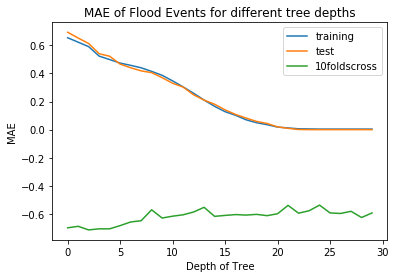

In [191]:
pyplot.plot(trainingf, label = "training" )
pyplot.plot(validationsetf,  label = "test")
pyplot.plot(crossvalf, label = "10foldscross")
pyplot.legend()
pyplot.title("MAE of Flood Events for different tree depths")
pyplot.xlabel("Depth of Tree")
pyplot.ylabel("MAE")

In [136]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = model.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", model.score(x_train, y_train))
print("Testing accuracy: ", model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, x_train_1, y_train_1, cv=10, scoring='max_error'))
weights = {"Linear":model.coef_}
df = pd.DataFrame(weights)
df.index = x_train.columns

MAE on training set  0.36339140350185284
MAE on testing set  0.5478156546037389
Cross validation set:  -0.4529544241349325
Training accuracy:  0.19946284387739407
Testing accuracy:  -0.08772126751136966
Cross validation accuracy:  [-0.41208992 -0.32047971 -0.2894912  -0.86830357 -0.50107524 -0.35637556
 -0.40332628 -0.32402693 -0.65578364 -0.39859219]
Cross validation accuracy:  [-0.31503772 -0.11530039 -0.21680499 -0.34667969 -0.23575655 -0.24658203
 -0.20403468 -0.18908691 -0.23040206 -0.23869932]
Cross validation accuracy:  [ -1.06069181  -3.78184891  -1.21776068 -15.27539062  -2.87591029
  -1.77929688  -3.66551023  -1.59863281  -5.15677753  -3.73481758]


In [137]:
ridgemodel = linear_model.Ridge(alpha=0.5)
ridgemodel.fit(x_train, y_train)
df['Ridge'] = ridgemodel.coef_
preds = ridgemodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = ridgemodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", ridgemodel.score(x_train, y_train))
print("Testing accuracy: ", ridgemodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(ridgemodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

MAE on training set  0.3708572570206105
MAE on testing set  0.5488681018962236
Cross validation set:  -0.436406907313752
Training accuracy:  0.19431602518168045
Testing accuracy:  -0.09410050841859219
Cross validation accuracy:  [-0.41066523 -0.31924317 -0.27891519 -0.76689144 -0.50018985 -0.30711043
 -0.41309459 -0.31141509 -0.65609808 -0.400446  ]
Cross validation accuracy:  [-0.31657729 -0.10356134 -0.2210961  -0.1526127  -0.23926777 -0.22998598
 -0.20451022 -0.17250751 -0.22238334 -0.24991444]
Cross validation accuracy:  [ -1.07001756  -3.77745824  -1.21234871 -15.12888819  -2.87832665
  -1.29209833  -3.69507584  -1.57317727  -5.22429919  -3.73385279]


In [ ]:
lassomodel = linear_model.Lasso(alpha=0.1)
lassomodel.fit(x_train, y_train)
df['Lasso'] = lassomodel.coef_
preds = lassomodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = lassomodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", lassomodel.score(x_train, y_train))
print("Testing accuracy: ", lassomodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(lassomodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

elmodel = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.7)
elmodel.fit(x_train, y_train)
df['ElasticNet'] = elmodel.coef_
preds = elmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = elmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", elmodel.score(x_train, y_train))
print("Testing accuracy: ", elmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(elmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

sgdmodel = linear_model.SGDRegressor()
sgdmodel.fit(x_train, y_train)
df['SGD'] = sgdmodel.coef_
preds = sgdmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = sgdmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", sgdmodel.score(x_train, y_train))
print("Testing accuracy: ", sgdmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

print("Cross validation accuracy: ", cross_val_score(sgdmodel, full_x, full_y, cv=10, scoring='max_error'))

sgdhmodel = linear_model.SGDRegressor(loss='huber')
sgdhmodel.fit(x_train,y_train)
df['SGD_huber'] = sgdhmodel.coef_
preds = sgdhmodel.predict(x_train)
print("MAE on training set ", metrics.mean_absolute_error(y_train, preds))
preds = sgdhmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", sgdhmodel.score(x_train, y_train))
print("Testing accuracy: ", sgdhmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(sgdhmodel, x_train_1, y_train_1, cv=10, scoring='max_error'))

print("Cross validation accuracy: ", cross_val_score(sgdhmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))

df

## Tree Models

dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(x_train_1,y_train_1)
preds = dtree.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = dtree.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(dtree, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", dtree.score(x_train_1, y_train_1))
print("Testing accuracy: ", dtree.score(x_test, y_test))
values = cross_val_score(dtree, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print(values.mean())

print("Cross validation accuracy: ", cross_val_score(dtree, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(model, full_x, full_y, cv=10, scoring='max_error'))

weights = {"DecisionTree":dtree.feature_importances_*100}
df_tree = pd.DataFrame(weights)
df_tree.index = x_train.columns

dt5model = DecisionTreeRegressor(max_depth=5)
dt5model.fit(x_train_1,y_train_1)
df_tree['DecisionTree5'] = dt5model.feature_importances_*100
preds = dt5model.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = dt5model.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(dt5model, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", dt5model.score(x_train_1, y_train_1))
print("Testing accuracy: ", dt5model.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(dt5model, full_x, full_y, cv=10, scoring='max_error'))

bmodel = BaggingRegressor(base_estimator=dtree)
bmodel.fit(x_train,y_train)

# base = model.base_estimator_.fit(x_train, y_train)
# df_tree['BaggingTreeBase'] = base.feature_importances_*100 #model.base_estimator_.feature_importances_
newfeature_importances = np.mean([
    tree.feature_importances_ for tree in bmodel.estimators_
], axis=0)
df_tree['BagginTreeAvg'] = newfeature_importances
preds = bmodel.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = bmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(bmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Cross validation set: ", values.mean())
print("Training accuracy: ", bmodel.score(x_train, y_train))
print("Testing accuracy: ", bmodel.score(x_test, y_test))
print("Cross validation MAE: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(bmodel, full_x, full_y, cv=10, scoring='max_error'))

rfmodel = RandomForestRegressor()
rfmodel.fit(x_train, y_train)
df_tree['RandomForest'] = rfmodel.feature_importances_*100
preds = rfmodel.predict(x_train_1)
print("MAE on training set ", metrics.mean_absolute_error(y_train_1, preds))
preds = rfmodel.predict(x_test)
print("MAE on testing set ", metrics.mean_absolute_error(y_test, preds))
values = cross_val_score(rfmodel, x_train_1, y_train_1, cv=10, scoring='neg_mean_absolute_error')
print("Training accuracy: ", rfmodel.score(x_train, y_train))
print("Testing accuracy: ", rfmodel.score(x_test, y_test))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='neg_mean_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='neg_median_absolute_error'))
print("Cross validation accuracy: ", cross_val_score(rfmodel, full_x, full_y, cv=10, scoring='max_error'))

df_tree